# Test SR model

In [9]:
import numpy as np 
import torch
from PIL import Image
import matplotlib.pyplot as plt

# 假设你的项目路径配置正确
from src.emcfsys.EMCellFiner.hat.models.hat_model import HATModel
from src.emcfsys.EMCellFiner.hat.models.img_utils import tensor2img

# 1. 初始化模型
path = r"D:\napari_EMCF\EMCFsys\models\EMCellFiner.pth"
# 显式指定 tile_size，防止显存溢出；对于小图可以不用 tile
model = HATModel(scale=4, tile_size=512) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# 2. 读取与预处理
img_path = r"D:\napari_EMCF\EMCFsys\emcfsys\image\Bock2011_2951_XrV1ciGgTWHjepNf.tif"
img = Image.open(img_path).convert("RGB")

# 转换为 Numpy 并归一化
img_np = np.array(img).astype(np.float32) / 255.
# 转换为 Tensor: (H, W, C) -> (C, H, W) -> (1, C, H, W)
img_torch = torch.from_numpy(img_np).permute(2, 0, 1).unsqueeze(0).to(device)
print(f"Input Shape: {img_torch.shape}")
# 3. 推理
with torch.no_grad():
    output = model(img_torch) 
print(f"Output Shape: {output.shape}")
# 4. 后处理
output = output.cpu()
img_out = tensor2img(output, rgb2bgr=False, min_max=(0, 1))
# 5. 转回 PIL 图片
img_final = Image.fromarray(img_out)

# 验证结果
# img_final.show() 
# img_final.save("result_sr.png")
print("Done.")

Using the model from torch hub : https://github.com/yzy0102/emcfsys/releases/latest/download/EMCellFiner.pth
Input Shape: torch.Size([1, 3, 1024, 1024])
	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4
Output Shape: torch.Size([1, 3, 4096, 4096])
Done.


In [1]:
from src.emcfsys.EMCellFiner.hat.models.inference_hat import hat_infer_numpy
from src.emcfsys.EMCellFiner.hat.models.hat_model import HATModel
from PIL import Image
import numpy as np
import torch
import time
start = time.time()
img_path = r"D:\napari_EMCF\EMCFsys\emcfsys\image\Bock2011_2951_XrV1ciGgTWHjepNf.tif"
img = Image.open(img_path).convert("RGB")
img_np = np.array(img)

model = HATModel(scale=4, tile_size=512)
device = "cuda" #torch.device("cuda" if torch.cuda.is_available() else "cpu")

out = hat_infer_numpy(
    model= model,
    image= img_np,
    device=device,
)
print(out.shape)
end = time.time()
print("inference time: ", end - start)

c:\Users\YZY\miniconda3\envs\EMCF_napari\Lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
c:\Users\YZY\miniconda3\envs\EMCF_napari\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Using the model from torch hub : https://github.com/yzy0102/emcfsys/releases/latest/download/EMCellFiner.pth
	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4
🕒 函数 'hat_infer_numpy' 执行完成，耗时: 17.6027 秒。
(4096, 4096, 3)
inference time:  17.958842992782593


In [2]:
out

array([[[153, 153, 153],
        [135, 135, 135],
        [120, 122, 123],
        ...,
        [199, 198, 199],
        [176, 175, 175],
        [177, 176, 176]],

       [[147, 146, 146],
        [139, 138, 139],
        [123, 123, 124],
        ...,
        [184, 185, 185],
        [197, 195, 196],
        [222, 221, 221]],

       [[138, 139, 139],
        [137, 137, 140],
        [120, 121, 121],
        ...,
        [194, 194, 194],
        [192, 193, 191],
        [216, 215, 214]],

       ...,

       [[172, 171, 169],
        [151, 150, 149],
        [170, 169, 169],
        ...,
        [153, 153, 152],
        [177, 176, 175],
        [162, 161, 160]],

       [[179, 178, 178],
        [167, 166, 165],
        [178, 178, 177],
        ...,
        [174, 174, 173],
        [179, 179, 178],
        [172, 171, 171]],

       [[181, 180, 179],
        [181, 180, 179],
        [171, 170, 169],
        ...,
        [161, 160, 159],
        [164, 163, 162],
        [165, 164, 163]]

# test SR stack images

In [ ]:
from src.emcfsys.EMCellFiner.hat.models.inference_hat import hat_infer_numpy
from src.emcfsys.EMCellFiner.hat.models.hat_model import HATModel
from PIL import Image
import numpy as np
import torch
import time
start = time.time()
# img_path = r"D:\napari_EMCF\EMCFsys\emcfsys\image\Bock2011_2951_XrV1ciGgTWHjepNf.tif"
# img = Image.open(img_path).convert("RGB").crop([0,0,512,512])

stack_path = [r"D:\CellChange\Bock3D\image\3004.jpg",
              r"D:\CellChange\Bock3D\image\3044.jpg",
              r"D:\CellChange\Bock3D\image\3054.jpg",]

# stack_path = [r"D:\CellChange\Bock3D\image\3004.jpg",]

stack_imgs = np.array([np.array(Image.open(p).convert("L").resize([1024,1024])) for p in stack_path])


model = HATModel(scale=4, tile_size=512)
device = "cuda" #torch.device("cuda" if torch.cuda.is_available() else "cpu")

out = hat_infer_numpy(
    model = model,
    image = stack_imgs,
    device =device,
)

end = time.time()
print("inference time: ", end - start)

Using the model from torch hub : https://github.com/yzy0102/emcfsys/releases/latest/download/EMCellFiner.pth
🕒 函数 'prepare_image' 执行完成，耗时: 0.0075 秒。
	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4
	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4
	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4
🕒 函数 'hat_infer_numpy' 执行完成，耗时: 46.0608 秒。
inference time:  46.45893836021423


In [12]:

out.shape

(3, 4096, 4096, 3)

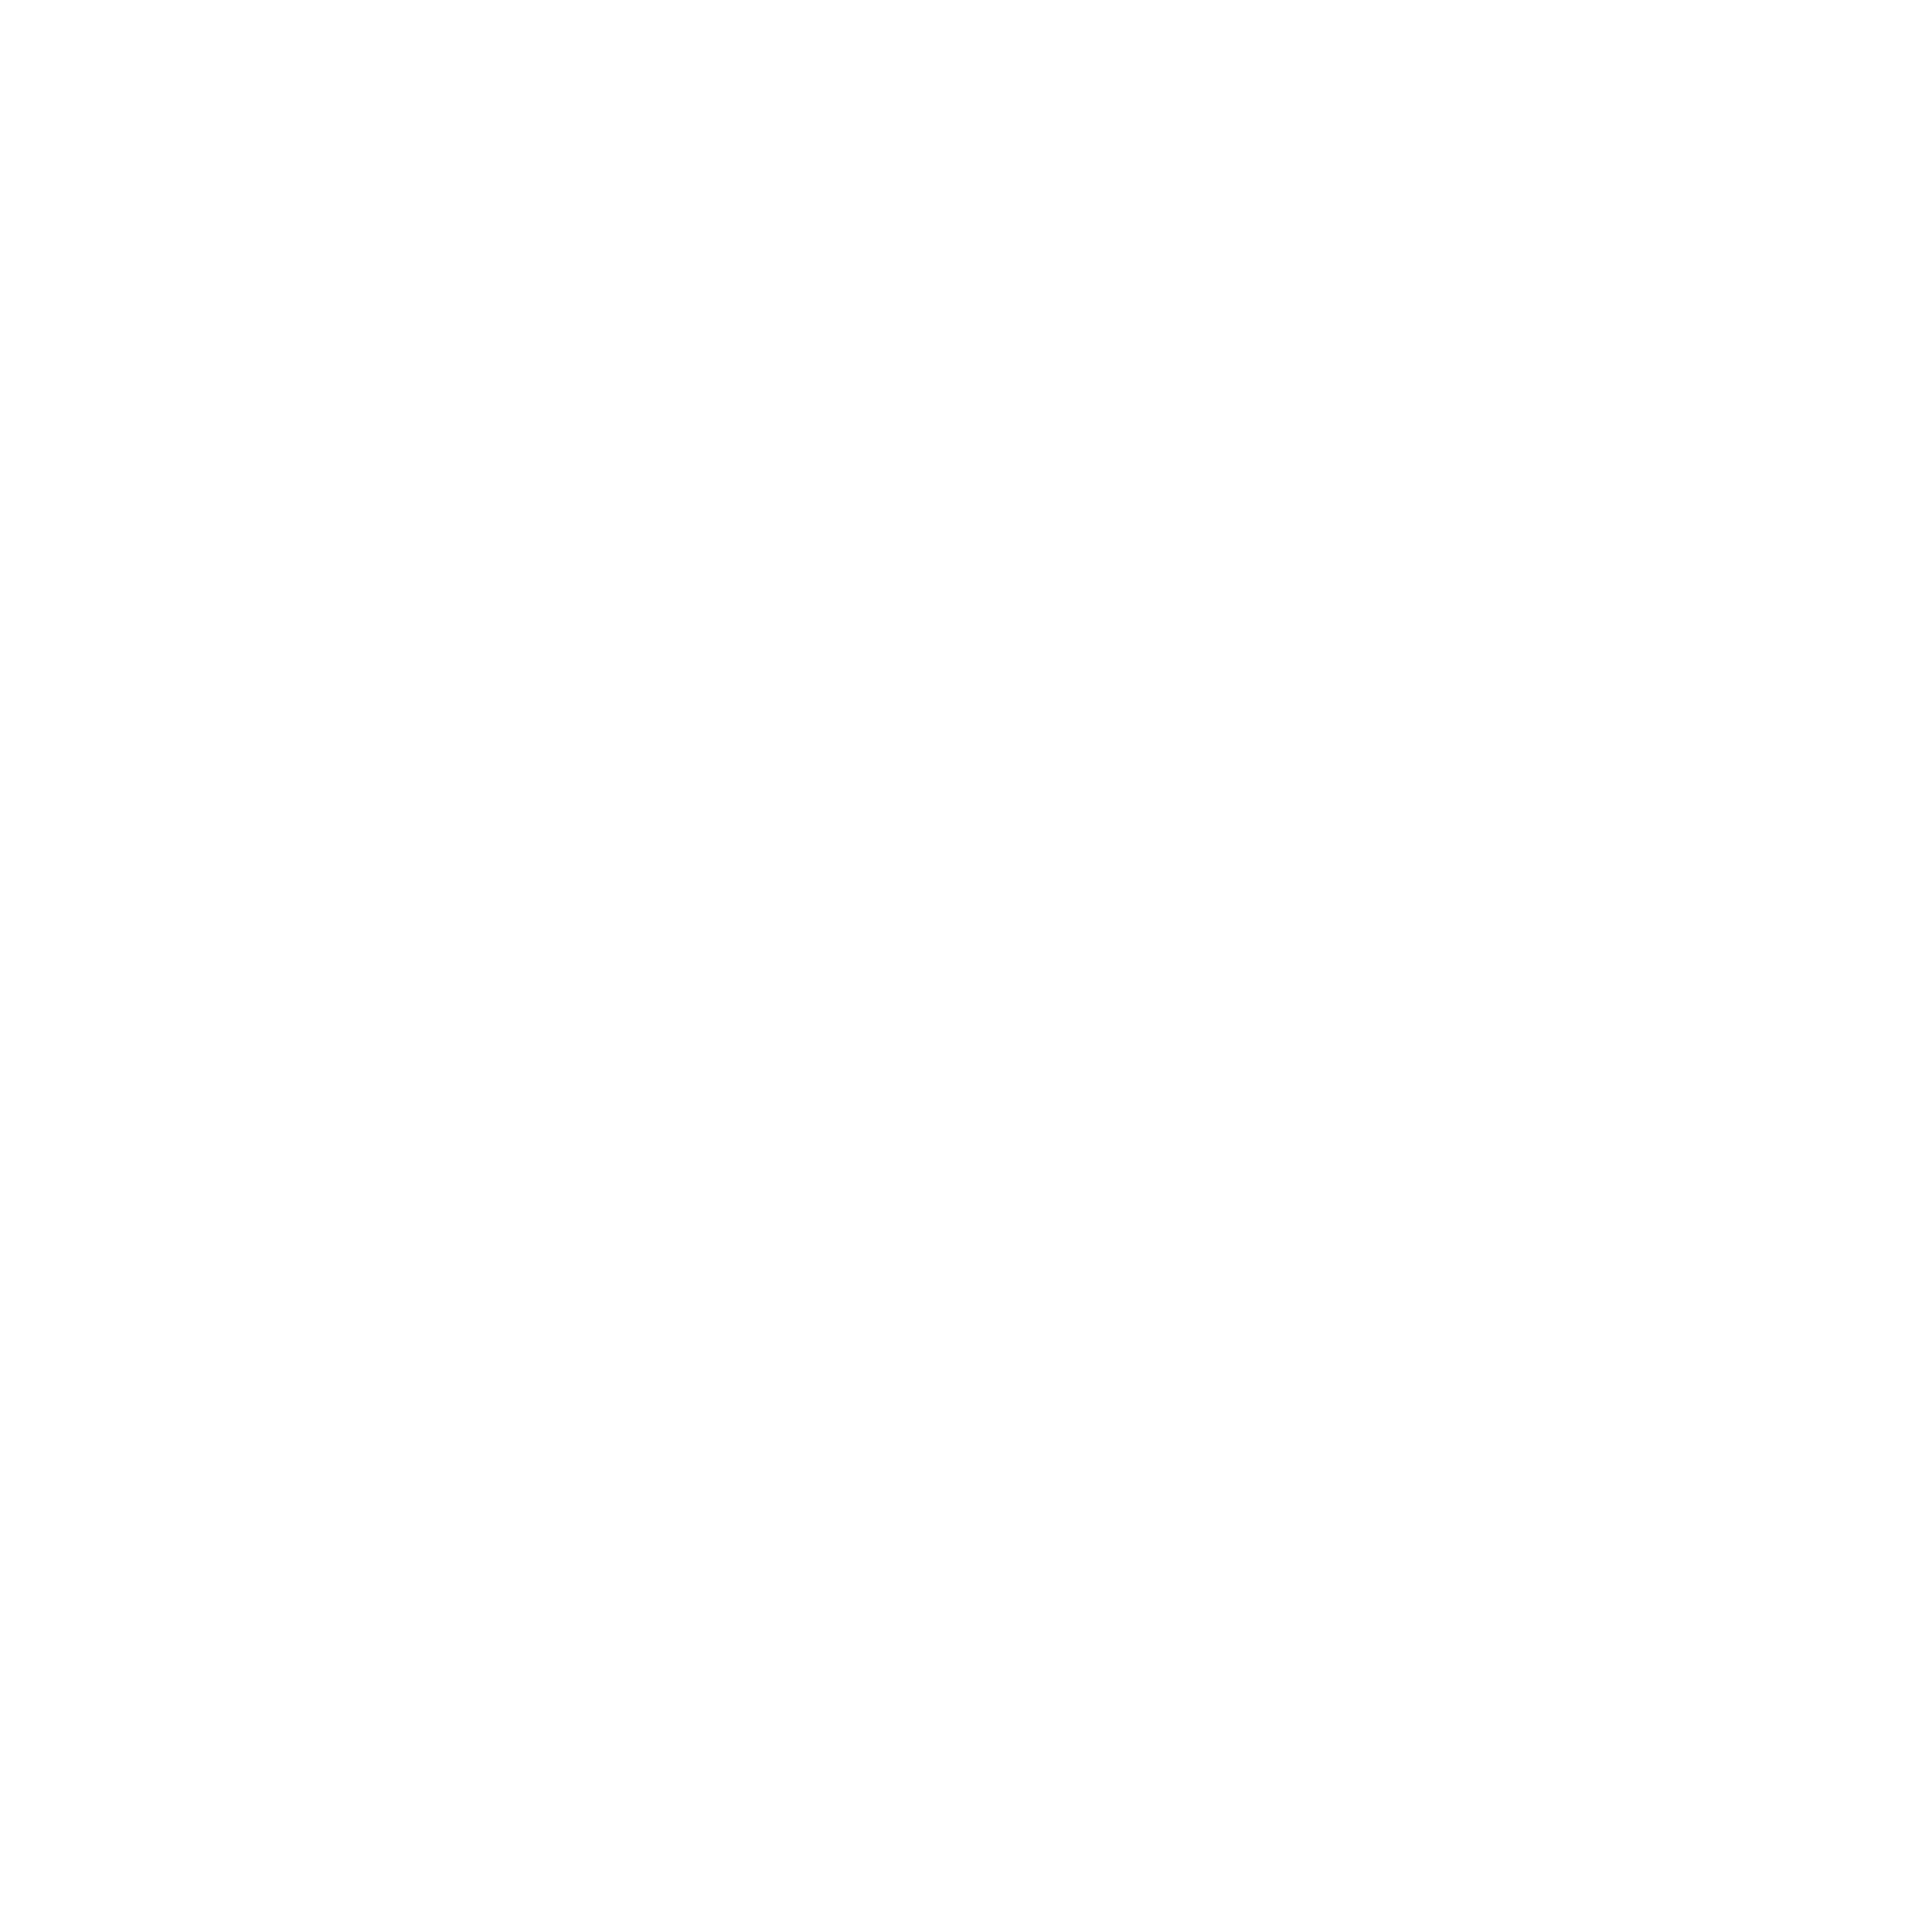

In [8]:
Image.fromarray(out[2,:,:,:]).convert("L")

In [ ]:
from urllib.request import urlopen
from PIL import Image
import timm

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model('vit_small_patch16_dinov3.lvd1689m', pretrained=True)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # unsqueeze single image into batch of 1

top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)


# test the train

In [ ]:
from src.emcfsys.EMCellFound.train import train_loop
import torch
img_dir = r"D:\ZJU-CUHK AI collab\QC\DL\masks\image"
label_dir = r"D:\ZJU-CUHK AI collab\QC\DL\masks\label"
save_dir = r"D:\ZJU-CUHK AI collab\QC\DL\masks\models"

logs = []
epoch_times = []
metrics_all = []
def cb(epoch, batch, n_batches, loss, finished_epoch=False, epoch_time=None, model_dict=None, metrics=None):

    # 保存 epoch 时间
    if finished_epoch and epoch_time is not None:
        epoch_times.append(epoch_time)

    if metrics is not None:
        metrics_all.append(metrics)
        
    # 保存 batch/epoch 日志
    logs.append((epoch, batch, n_batches, loss, finished_epoch, epoch_time, metrics))

    # 输出日志
    if batch == 0 and finished_epoch:
        if epoch_time is not None:
            print(f"Epoch {epoch} finished, avg loss {loss:.4f}, time {epoch_time:.2f}s, metric {metrics}" )


train_loop(img_dir, 
           label_dir, 
           save_dir, 
           model_name='unet',
           backbone_name='convnext_base',
           pretrained = True,
           pretrained_model=None,
           lr=1e-4, batch_size=8, 
           epochs=1000, device=None,
           callback=cb, target_size=(1024, 1024),
           classes_num=4, ignore_index=-1)

New best model found at epoch 1! Val IoU=0.1528
Epoch 1 finished, avg loss 4.2767, time 1.49s, metric {'IoU': 0.008203729856177233, 'Accuracy': 0.03235562890768051, 'F1': 0.015895996330073103, 'Val_IoU': 0.1527724687330192, 'Val_Accuracy': 0.6079063415527344, 'Val_F1': 0.18980497078155167}
New best model found at epoch 2! Val IoU=0.1767
Epoch 2 finished, avg loss 2.9302, time 1.19s, metric {'IoU': 0.19307168935483787, 'Accuracy': 0.770331084728241, 'F1': 0.21793735744722653, 'Val_IoU': 0.17669296264648438, 'Val_Accuracy': 0.7067718505859375, 'Val_F1': 0.2070491909980774}
New best model found at epoch 3! Val IoU=0.2003
Epoch 3 finished, avg loss 2.8483, time 1.17s, metric {'IoU': 0.2026270180940628, 'Accuracy': 0.810508131980896, 'F1': 0.2238343209028244, 'Val_IoU': 0.20030975341796875, 'Val_Accuracy': 0.801239013671875, 'Val_F1': 0.22241318225860596}
Epoch 4 finished, avg loss 2.3385, time 0.85s, metric {'IoU': 0.21867895126342773, 'Accuracy': 0.8747158050537109, 'F1': 0.23329278826713

In [ ]:
New best model found at epoch 84! Val IoU=0.7845
New best model found at epoch 34! Val IoU=0.7566

# Inference the seg model

Pretrained weights loaded successfully.
Pretrained weights loaded successfully.
🕒 函数 'prepare_image' 执行完成，耗时: 0.0045 秒。
🕒 函数 'infer_numpy' 执行完成，耗时: 0.0395 秒。
(512, 512) [0 1]


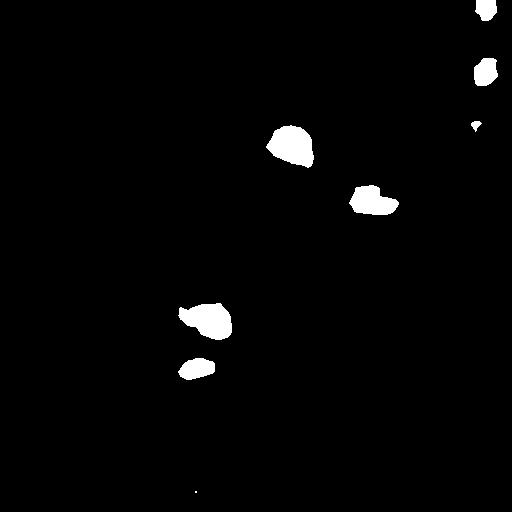

In [3]:
from src.emcfsys.EMCellFound.inference import infer_numpy, load_model
from src.emcfsys.EMCellFound.utils.checkpoint import load_pretrained
import numpy as np
import torch
from PIL import Image
from src.emcfsys.EMCellFound.models.model_factory import get_model
from src.emcfsys.EMCellFound.models.DeepLabv3Plus import DeepLabV3Plus

# img_path = r"D:\napari_EMCF\EMCFsys\emcfsys\image\Bock2011_2951_xZGgUFHBDISQMdco.tif"
img_path = r"D:\CellChange\Bock3D\image\3004.jpg"


model_path = r"D:\napari_EMCF\EMCFsys\models\best_model_epoch99_IoU=0.8046.pth"
# 构建 + 加载模型
model = load_model(model_name="deeplabv3plus", 
                   backbone_name="emcellfound_vit_base", 
                   num_classes=2, 
                   model_path=model_path, 
                   aux_on=False, 
                   device="cuda")

# 加载图像
img = np.array(Image.open(img_path).convert("RGB").resize((512, 512)))

# 推理
mask = infer_numpy(model, img, device="cuda")
print(mask.shape, np.unique(mask))
Image.fromarray(mask*255)

# test the infer_numpy function

In [4]:
from src.emcfsys.EMCellFound.inference import infer_numpy, load_model, infer_full_image
from src.emcfsys.EMCellFound.utils.checkpoint import load_pretrained
import numpy as np
import torch
from PIL import Image
from src.emcfsys.EMCellFound.models.model_factory import get_model
from src.emcfsys.EMCellFound.models.DeepLabv3Plus import DeepLabV3Plus


img_path = r"D:\napari_EMCF\EMCFsys\emcfsys\image\Bock2011_2951_xZGgUFHBDISQMdco.tif"

stack_path = [r"D:\CellChange\Bock3D\image\3004.jpg",
              r"D:\CellChange\Bock3D\image\3014.jpg",
              r"D:\CellChange\Bock3D\image\3024.jpg",
              r"D:\CellChange\Bock3D\image\3034.jpg",
              r"D:\CellChange\Bock3D\image\3044.jpg",
              r"D:\CellChange\Bock3D\image\3054.jpg",]

# stack_path = [r"D:\CellChange\Bock3D\image\3004.jpg",]

stack_imgs = np.array([np.array(Image.open(p).convert("RGB")) for p in stack_path])
print(stack_imgs.shape)


model_path = r"D:\napari_EMCF\EMCFsys\models\best_model_epoch99_IoU=0.8046.pth"

# 构建 + 加载模型

model = load_model(model_name="deeplabv3plus", 
                   backbone_name="emcellfound_vit_base", 
                   num_classes=2, 
                   model_path=model_path, 
                   aux_on=False, 
                   device="cuda")

# 加载图像

# 推理
mask = infer_full_image(model, stack_imgs, (512,512), device="cuda")
print(mask.shape, np.unique(mask))


(6, 2048, 2048, 3)
Pretrained weights loaded successfully.
Pretrained weights loaded successfully.
🕒 函数 'prepare_image' 执行完成，耗时: 0.3599 秒。
🕒 函数 'infer_full_image' 执行完成，耗时: 0.6361 秒。
(6, 2048, 2048) [0 1]


# Test slide inference

In [ ]:
from src.emcfsys.EMCellFound.inference import infer_numpy, load_model, infer_full_image, infer_sliding_window
from src.emcfsys.EMCellFound.utils.checkpoint import load_pretrained
import numpy as np
import torch
from PIL import Image
from src.emcfsys.EMCellFound.models.model_factory import get_model
from src.emcfsys.EMCellFound.models.DeepLabv3Plus import DeepLabV3Plus


img_path = r"D:\napari_EMCF\EMCFsys\emcfsys\image\Bock2011_2951_xZGgUFHBDISQMdco.tif"

stack_path = [r"D:\CellChange\Bock3D\image\3004.jpg",
              r"D:\CellChange\Bock3D\image\3014.jpg",
              r"D:\CellChange\Bock3D\image\3024.jpg",
              r"D:\CellChange\Bock3D\image\3034.jpg",
              r"D:\CellChange\Bock3D\image\3044.jpg",
              r"D:\CellChange\Bock3D\image\3054.jpg",]

# stack_path = [r"D:\CellChange\Bock3D\image\3004.jpg",]

stack_imgs = np.array([np.array(Image.open(p).convert("RGB")) for p in stack_path])
print(stack_imgs.shape)


model_path = r"D:\napari_EMCF\EMCFsys\models\best_model_epoch98_IoU=0.9024.pth"

# 构建 + 加载模型

model = load_model(model_name="deeplabv3plus", 
                   backbone_name="emcellfound_vit_base", 
                   num_classes=2, 
                   model_path=model_path, 
                   aux_on=False, 
                   device="cuda")

# 加载图像

# 推理

mask = infer_sliding_window(model=model, image=stack_imgs, window_size= 512, 
    overlap = 0.25, out_channels=2, img_size = (512,512), device = "cuda",)

print(mask.shape, np.unique(mask))


In [47]:
from PIL import Image
import numpy as np
import skimage
img = Image.open(r"D:\ZJU-CUHK AI collab\RAYdata\test_data0086.tif")
img_np_32bit = np.array(img)
print(img_np_32bit)

print("32bit:", img_np_32bit.max())
print("8bit:", img_np_32bit.astype(np.uint8).max())

sk_img = skimage.io.imread(r"D:\ZJU-CUHK AI collab\RAYdata\test_data0086.tif").astype(np.uint8)
print("skimage 8bit:", sk_img.max())

[[0.01674455 0.0143365  0.01818207 ... 0.01964568 0.01653717 0.01273447]
 [0.01934546 0.01742006 0.0180804  ... 0.01471872 0.01957426 0.01572852]
 [0.01911131 0.01578239 0.01833347 ... 0.01384553 0.01976059 0.01821711]
 ...
 [0.01480731 0.01647856 0.0160673  ... 0.01290788 0.02086926 0.01273654]
 [0.01497095 0.01632275 0.01407245 ... 0.01475996 0.01795666 0.01574175]
 [0.01622406 0.01581718 0.01569481 ... 0.01600669 0.01576876 0.01327758]]
32bit: 0.036466397
8bit: 0
skimage 8bit: 0


In [51]:
from PIL import Image
import numpy as np
img = Image.open(r"D:\ZJU-CUHK AI collab\RAYdata\0008bit.tif")
img_np = np.array(img)
img_np.max()

np.uint8(252)

In [52]:
import numpy as np

def normalize_to_uint8(
    img,
    method="percentile",
    pmin=1,
    pmax=99,
    eps=1e-8
):
    """
    Robustly normalize arbitrary numpy image to uint8 [0,255].

    Parameters
    ----------
    img : np.ndarray
        Input image of any dtype (uint8/16/32/float/etc.)
    method : str
        'minmax' or 'percentile'
    pmin, pmax : float
        Percentiles used when method='percentile'
    eps : float
        Small value to avoid division by zero
    """

    if img is None:
        raise ValueError("Input image is None")

    img = np.asarray(img)

    # 1. already uint8 → return safely
    if img.dtype == np.uint8:
        return img

    # 2. convert to float32
    img_f = img.astype(np.float32)

    # 3. handle NaN / Inf
    img_f = np.nan_to_num(img_f, nan=0.0, posinf=0.0, neginf=0.0)

    # 4. determine range
    if method == "minmax":
        vmin = img_f.min()
        vmax = img_f.max()
    elif method == "percentile":
        vmin = np.percentile(img_f, pmin)
        vmax = np.percentile(img_f, pmax)
    else:
        raise ValueError(f"Unknown method: {method}")

    # 5. avoid degenerate case
    if abs(vmax - vmin) < eps:
        return np.zeros_like(img_f, dtype=np.uint8)

    # 6. normalize
    img_norm = (img_f - vmin) / (vmax - vmin)
    img_norm = np.clip(img_norm, 0.0, 1.0)

    # 7. map to uint8
    return (img_norm * 255).astype(np.uint8)


In [55]:
normalize_to_uint8(img_np).max()

np.uint8(252)

In [58]:
from PIL import Image
import numpy as np

img = Image.open(r"D:\ZJU-CUHK AI collab\RAYdata\test_data0086.tif")
img_np_32bit = np.array(img)
print(img_np_32bit)

print("32bit:", img_np_32bit.max())
print("8bit:", img_np_32bit.astype(np.uint8).max())

normalize_img = normalize_to_uint8(img_np_32bit)
print("normalized 8bit:", normalize_img.max())

[[0.01674455 0.0143365  0.01818207 ... 0.01964568 0.01653717 0.01273447]
 [0.01934546 0.01742006 0.0180804  ... 0.01471872 0.01957426 0.01572852]
 [0.01911131 0.01578239 0.01833347 ... 0.01384553 0.01976059 0.01821711]
 ...
 [0.01480731 0.01647856 0.0160673  ... 0.01290788 0.02086926 0.01273654]
 [0.01497095 0.01632275 0.01407245 ... 0.01475996 0.01795666 0.01574175]
 [0.01622406 0.01581718 0.01569481 ... 0.01600669 0.01576876 0.01327758]]
32bit: 0.036466397
8bit: 0
normalized 8bit: 255
